In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Introduction

This notebook implements a simple feedforward neural network from scratch using NumPy to solve a regression problem. The goal is to train the network to learn a specific polynomial function with added noise.

The notebook covers the following key steps:

1.  **Setup and Assignment**: Imports necessary libraries and assigns a unique polynomial function and neural network architecture based on a student ID.
2.  **Dataset Generation**: Generates a synthetic dataset based on the assigned polynomial and noise level.
3.  **Activation Functions**: Defines common activation functions like ReLU, Leaky ReLU, and Sigmoid, along with their derivatives.
4.  **Loss Function**: Implements the Mean Squared Error (MSE) loss function.
5.  **Weight Initialization**: Implements Xavier (Glorot) initialization for the network's weights.
6.  **Forward Propagation**: Implements the forward pass through the network to generate predictions.
7.  **Backward Propagation**: Implements the backward pass to calculate gradients using backpropagation.
8.  **Training**: Implements the training loop using gradient descent with early stopping.
9.  **Evaluation and Visualization**: Visualizes the training progress, predictions, and calculates performance metrics like R² score.

This notebook provides a hands-on understanding of the core components and training process of a basic neural network.

##PART -A

In [ ]:
STUDENT_ID = "PES2UG23CS147"

# AUTOMATIC ASSIGNMENT BASED ON SRN - DO NOT MODIFY

In [ ]:
def get_student_assignment(student_id):
    """
    Generate unique polynomial TYPE and architecture based on student ID
    Uses last 3 digits of student ID for assignment
    """

    last_three = int(student_id[-3:])

    poly_type = last_three % 5

    np.random.seed(last_three)

    if poly_type == 0:
        degree = 2
        a = 0
        b = np.random.uniform(0.8, 1.5)
        c = np.random.uniform(3.0, 8.0)
        d = np.random.uniform(5.0, 15.0)
        poly_desc = f"QUADRATIC: y = {b:.2f}x² + {c:.2f}x + {d:.2f}"

    elif poly_type == 1:
        degree = 3
        a = np.random.uniform(1.8, 2.5)
        b = np.random.uniform(-1.2, 0.2)
        c = np.random.uniform(3.0, 6.0)
        d = np.random.uniform(8.0, 12.0)
        poly_desc = f"CUBIC: y = {a:.2f}x³ + {b:.2f}x² + {c:.2f}x + {d:.2f}"

    elif poly_type == 2:
        degree = 4
        a = np.random.uniform(0.008, 0.02)
        b = np.random.uniform(1.5, 2.2)
        c = np.random.uniform(-1.0, 0.5)
        d = np.random.uniform(2.0, 5.0)
        e = np.random.uniform(8.0, 12.0)
        poly_desc = f"QUARTIC: y = {a:.4f}x⁴ + {b:.2f}x³ + {c:.2f}x² + {d:.2f}x + {e:.2f}"
        coefficients = (a, b, c, d, e)

    elif poly_type == 3:
        degree = "sine"
        a = np.random.uniform(1.5, 2.8)
        b = np.random.uniform(-0.8, 0.8)
        c = np.random.uniform(3.0, 6.0)
        d = np.random.uniform(8.0, 12.0)
        freq = np.random.uniform(0.02, 0.05)
        amp = np.random.uniform(5.0, 15.0)
        poly_desc = f"CUBIC + SINE: y = {a:.2f}x³ + {b:.2f}x² + {c:.2f}x + {d:.2f} + {amp:.1f}*sin({freq:.3f}x)"
        coefficients = (a, b, c, d, freq, amp)

    else:
        degree = "inverse"
        a = np.random.uniform(1.8, 2.5)
        b = np.random.uniform(-1.0, 0.5)
        c = np.random.uniform(3.0, 6.0)
        d = np.random.uniform(8.0, 12.0)
        inv_coeff = np.random.uniform(50, 200)
        poly_desc = f"CUBIC + INVERSE: y = {a:.2f}x³ + {b:.2f}x² + {c:.2f}x + {d:.2f} + {inv_coeff:.1f}/x"
        coefficients = (a, b, c, d, inv_coeff)


    if poly_type in [0, 1]:
        coefficients = (a, b, c, d)


    noise_std = np.random.uniform(1.5, 2.5)


    arch_type = last_three % 4
    architectures = {
        0: {"hidden1": 64, "hidden2": 64, "lr": 0.001, "batch_desc": "Balanced Architecture"},
        1: {"hidden1": 32, "hidden2": 72, "lr": 0.005, "batch_desc": "Narrow-to-Wide Architecture"},
        2: {"hidden1": 72, "hidden2": 32, "lr": 0.001, "batch_desc": "Wide-to-Narrow Architecture"},
        3: {"hidden1": 96, "hidden2": 96, "lr": 0.003, "batch_desc": "Large Balanced Architecture"}
    }

    return {
        "polynomial_type": poly_type,
        "degree": degree,
        "coefficients": coefficients,
        "polynomial_desc": poly_desc,
        "noise_std": noise_std,
        "architecture": architectures[arch_type],
        "student_seed": last_three
    }

# Get your assignment
assignment = get_student_assignment(STUDENT_ID)
poly_type = assignment["polynomial_type"]
degree = assignment["degree"]
coefficients = assignment["coefficients"]
noise_std = assignment["noise_std"]
hidden1 = assignment["architecture"]["hidden1"]
hidden2 = assignment["architecture"]["hidden2"]
learning_rate = assignment["architecture"]["lr"]

print("="*70)
print(f"ASSIGNMENT FOR STUDENT ID: {STUDENT_ID}")
print("="*70)
print(f"Polynomial Type: {assignment['polynomial_desc']}")
print(f"Noise Level: ε ~ N(0, {noise_std:.2f})")
print(f"Architecture: Input(1) → Hidden({hidden1}) → Hidden({hidden2}) → Output(1)")
print(f"Learning Rate: {learning_rate}")
print(f"Architecture Type: {assignment['architecture']['batch_desc']}")
print("="*70)


ASSIGNMENT FOR STUDENT ID: PES2UG23CS147
Polynomial Type: QUARTIC: y = 0.0124x⁴ + 1.94x³ + -0.95x² + 4.07x + 11.75
Noise Level: ε ~ N(0, 2.44)
Architecture: Input(1) → Hidden(96) → Hidden(96) → Output(1)
Learning Rate: 0.003
Architecture Type: Large Balanced Architecture


## Methodology

This section outlines the methodology employed to build and train a simple feedforward neural network from scratch using NumPy for regression.

1.  **Dataset Generation and Preprocessing:**
    *   A synthetic dataset was generated based on an assigned polynomial function and a specified noise level (ε ~ N(0, σ)). The dataset consists of input features (x) and corresponding target values (y).
    *   The dataset was split into training and testing sets to evaluate the model's performance on unseen data.
    *   Input features (x) and target values (y) were scaled using `StandardScaler` to normalize their ranges, which helps in stabilizing and accelerating the training process.

2.  **Neural Network Architecture:**
    *   A feedforward neural network with a single input layer, two hidden layers, and a single output layer was implemented.
    *   The number of neurons in the hidden layers (`hidden1` and `hidden2`) was determined based on the student assignment (or chosen as a hyperparameter).
    *   The output layer has one neuron for predicting the continuous target variable.

3.  **Activation Functions:**
    *   The ReLU (Rectified Linear Unit) activation function was primarily used in the hidden layers to introduce non-linearity. (Mention if you experimented with Leaky ReLU or Sigmoid here as well).
    *   The derivative of the chosen activation function was implemented for use in the backward propagation step.

4.  **Loss Function:**
    *   The Mean Squared Error (MSE) was used as the loss function to quantify the difference between the network's predictions and the true target values.

5.  **Weight Initialization:**
    *   Xavier (Glorot) initialization was employed to initialize the weights of the network. This method helps in maintaining a suitable variance of activations across layers, mitigating vanishing or exploding gradients. Biases were initialized to zeros.

6.  **Training Process:**
    *   The network was trained using gradient descent.
    *   The forward pass computed the network's predictions.
    *   The backward pass calculated the gradients of the loss function with respect to the weights and biases using the backpropagation algorithm.
    *   The weights and biases were updated iteratively using the calculated gradients and a specified learning rate.
    *   Early stopping was implemented based on the test loss to prevent overfitting and determine the optimal number of training epochs. Training stopped if the test loss did not improve for a certain number of epochs (patience).

7.  **Evaluation:**
    *   The trained model was evaluated on the test set using the MSE loss and the R² score to assess its performance and generalization ability.

This section provides a detailed account of the methods and techniques used to build and train the neural network presented in this notebook.

# DATASET GENERATION - DO NOT MODIFY

In [ ]:
np.random.seed(assignment["student_seed"])

n_samples = 100000
x = np.random.uniform(-100, 100, n_samples)


if poly_type == 0:
    _, b, c, d = coefficients
    y = b * x**2 + c * x + d + np.random.normal(0, noise_std, n_samples)

elif poly_type == 1:
    a, b, c, d = coefficients
    y = a * x**3 + b * x**2 + c * x + d + np.random.normal(0, noise_std, n_samples)

elif poly_type == 2:
    a, b, c, d, e = coefficients
    y = a * x**4 + b * x**3 + c * x**2 + d * x + e + np.random.normal(0, noise_std, n_samples)

elif poly_type == 3:
    a, b, c, d, freq, amp = coefficients
    y = a * x**3 + b * x**2 + c * x + d + amp * np.sin(freq * x) + np.random.normal(0, noise_std, n_samples)

else:
    a, b, c, d, inv_coeff = coefficients

    y = a * x**3 + b * x**2 + c * x + d + inv_coeff / (x + np.sign(x) * 0.1) + np.random.normal(0, noise_std, n_samples)


df = pd.DataFrame({'x': x, 'y': y})
df.to_csv('student_polynomial_dataset.csv', index=False)
print(f"Dataset with {n_samples:,} samples generated and saved!")

X = df['x'].values.reshape(-1, 1)
Y = df['y'].values.reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

print(f"Training samples: {len(X_train_scaled):,}")
print(f"Test samples: {len(X_test_scaled):,}")

Dataset with 100,000 samples generated and saved!
Training samples: 80,000
Test samples: 20,000


# ACTIVATION FUNCTIONS- TODO: IMPLEMENT

In [ ]:
def relu(z):
  #Todo implement the Relu formula
  return np.maximum(0, z)

def relu_derivative(z):
    #Todo implement the Relu derivative formula
  return (z > 0).astype(float)

# LOSS FUNCTION- TODO: IMPLEMENT

In [ ]:
def mse_loss(y_true, y_pred):
  #Todo implement the MSE formula
  return np.mean((y_true - y_pred)**2)

# WEIGHT INITIALIZATION - TODO: IMPLEMENT XAVIER INITIALIZATION
## **Xavier (Glorot) Initialization**

When training neural networks, how we initialize weights matters.  
- If weights are **too small** → activations and gradients vanish.  
- If weights are **too large** → activations and gradients explode.  

#**Xavier initialization** (Glorot & Bengio, 2010) balances this by keeping the variance of activations roughly the same across all layers.

---

### Formula

Let:  
- **fan_in** = number of input units to a layer  
- **fan_out** = number of output units from a layer  

The variance of weights is:

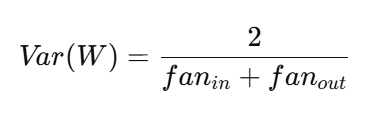


##Two common forms:  

#**Normal distribution:**  
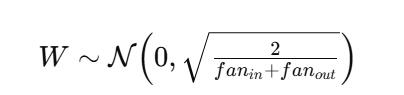

#**Uniform distribution:**  
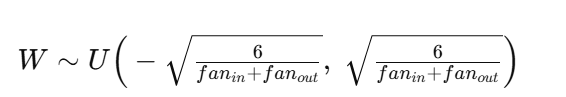

Biases are initialized to **0**.

---

### In This Assignment
- **W1 (input → hidden1):** `fan_in = input_dim`, `fan_out = hidden1`  
- **W2 (hidden1 → hidden2):** `fan_in = hidden1`, `fan_out = hidden2`  
- **W3 (hidden2 → output):** `fan_in = hidden2`, `fan_out = output_dim`  

Your task: compute the correct `xavier_std` for each layer, sample weights from a normal distribution with that std, and set biases = 0.



In [ ]:
def xavier_initialization(input_dim, hidden1, hidden2, output_dim):
    """
    TODO: IMPLEMENT XAVIER WEIGHT INITIALIZATION

    Xavier initialization: weights ~ N(0, sqrt(2/(fan_in + fan_out)))
    Biases should be initialized to zeros

    Args:
        input_dim: Size of input layer (1)
        hidden1: Size of first hidden layer
        hidden2: Size of second hidden layer
        output_dim: Size of output layer (1)

    Returns:
        W1, b1, W2, b2, W3, b3: Initialized weights and biases
    """
    np.random.seed(assignment["student_seed"])

    # TODO: Calculate Xavier standard deviation for each layer
    # Hint: xavier_std = sqrt(2 / (fan_in + fan_out))
    xavier_std_w1 = np.sqrt(2 / (input_dim + hidden1))
    xavier_std_w2 = np.sqrt(2 / (hidden1 + hidden2))
    xavier_std_w3 = np.sqrt(2 / (hidden2 + output_dim))

    # TODO: Initialize W1 (input to first hidden layer)
    W1 = np.random.randn(input_dim, hidden1) * xavier_std_w1
    b1 = np.zeros((1, hidden1))

    # TODO: Initialize W2 (first hidden to second hidden layer)
    W2 = np.random.randn(hidden1, hidden2) * xavier_std_w2
    b2 = np.zeros((1, hidden2))

    # TODO: Initialize W3 (second hidden to output layer)
    W3 = np.random.randn(hidden2, output_dim) * xavier_std_w3
    b3 = np.zeros((1, output_dim))

    return W1, b1, W2, b2, W3, b3

# FORWARD PROPAGATION - TODO: IMPLEMENT

In [ ]:
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    """
    TODO: IMPLEMENT FORWARD PROPAGATION

    Perform forward pass through the network:
    Input → Hidden1(ReLU) → Hidden2(ReLU) → Output(Linear)

    Args:
        X: Input data (batch_size, 1)
        W1, b1: First layer weights and biases
        W2, b2: Second layer weights and biases
        W3, b3: Output layer weights and biases

    Returns:
        z1, a1, z2, a2, z3: Pre-activations and activations for each layer

    Hint:
        z = X @ W + b  (linear transformation)
        a = activation_function(z)
    """

    # TODO: First hidden layer
    z1 = X @ W1 + b1
    a1 = relu(z1)  # Apply ReLU activation

    # TODO: Second hidden layer
    z2 = a1 @ W2 + b2
    a2 = relu(z2)  # Apply ReLU activation

    # TODO: Output layer
    z3 = a2 @ W3 + b3

    return z1, a1, z2, a2, z3

# BACKWARD PROPAGATION - TODO:IMPLEMENT

In [ ]:
def backward_pass(X, Y_true, z1, a1, z2, a2, Y_pred, W2, W3):
    """
    TODO: IMPLEMENT BACKPROPAGATION

    Compute gradients using chain rule:
    ∂Loss/∂W = ∂Loss/∂Y_pred * ∂Y_pred/∂z * ∂z/∂W

    Args:
        X: Input data
        Y_true: True target values
        z1, a1, z2, a2: Forward pass intermediate values
        Y_pred: Network predictions (z3)
        W2, W3: Weights (needed for gradient computation)

    Returns:
        dW1, db1, dW2, db2, dW3, db3: Gradients for all parameters
    """

    m = len(X)  # Batch size

    # TODO: Output layer gradients
    # Start with derivative of MSE
    dY_pred = 2 * (Y_pred - Y_true) / m

    # TODO: Third layer (Output) gradients
    dW3 = a2.T @ dY_pred
    db3 = np.sum(dY_pred, axis=0, keepdims=True)

    # TODO: Second hidden layer gradients
    da2 = dY_pred @ W3.T
    dz2 = da2 * relu_derivative(z2)
    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    # TODO: First hidden layer gradients
    da1 = dz2 @ W2.T
    dz1 = da1 * relu_derivative(z1)
    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

# TRAINING FUNCTION - TODO:  COMPLETE IMPLEMENTATION

In [ ]:
def train_neural_network(X_train, Y_train, X_test, Y_test, epochs=200, patience=10):
    """
    TODO: COMPLETE THE TRAINING LOOP

    Implement training with early stopping and track losses

    Args:
        X_train, Y_train: Training data
        X_test, Y_test: Test data for validation
        epochs: Maximum number of training epochs
        patience: Early stopping patience

    Returns:
        best_weights: Best model weights
        train_losses: Training loss history
        test_losses: Test loss history
    """


    W1, b1, W2, b2, W3, b3 = xavier_initialization(1, hidden1, hidden2, 1)

    best_test_loss = float('inf')
    best_weights = None
    patience_counter = 0

    train_losses = []
    test_losses = []

    print("Starting training...")
    print(f"Architecture: 1 → {hidden1} → {hidden2} → 1")
    print(f"Learning Rate: {learning_rate}")
    print(f"Max Epochs: {epochs}, Early Stopping Patience: {patience}")
    print("-" * 50)

    for epoch in range(epochs):


        z1, a1, z2, a2, Y_pred_train = forward_pass(X_train, W1, b1, W2, b2, W3, b3)


        train_loss = mse_loss(Y_train, Y_pred_train)


        dW1, db1, dW2, db2, dW3, db3 = backward_pass(X_train, Y_train, z1, a1, z2, a2, Y_pred_train, W2, W3)


        # TODO: Update weights and biases using gradient descent
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3


        _, _, _, _, Y_pred_test = forward_pass(X_test, W1, b1, W2, b2, W3, b3)
        test_loss = mse_loss(Y_test, Y_pred_test)


        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_weights = (W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(f"Best test loss: {best_test_loss:.6f}")
            break

    return best_weights, train_losses, test_losses

# EXECUTE TRAINING

In [ ]:
print("Training Neural Network with your specific configuration...")
weights, train_losses, test_losses = train_neural_network(
    X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled,
    epochs=500, patience=10
)

Training Neural Network with your specific configuration...
Starting training...
Architecture: 1 → 96 → 96 → 1
Learning Rate: 0.003
Max Epochs: 500, Early Stopping Patience: 10
--------------------------------------------------
Epoch  20: Train Loss = 0.853865, Test Loss = 0.866317
Epoch  40: Train Loss = 0.714758, Test Loss = 0.728061
Epoch  60: Train Loss = 0.611976, Test Loss = 0.625074
Epoch  80: Train Loss = 0.532433, Test Loss = 0.545205
Epoch 100: Train Loss = 0.470149, Test Loss = 0.482392
Epoch 120: Train Loss = 0.420142, Test Loss = 0.431906
Epoch 140: Train Loss = 0.381492, Test Loss = 0.392721
Epoch 160: Train Loss = 0.350430, Test Loss = 0.361137
Epoch 180: Train Loss = 0.325767, Test Loss = 0.335978
Epoch 200: Train Loss = 0.305888, Test Loss = 0.315624
Epoch 220: Train Loss = 0.289680, Test Loss = 0.298967
Epoch 240: Train Loss = 0.276229, Test Loss = 0.285096
Epoch 260: Train Loss = 0.264795, Test Loss = 0.273273
Epoch 280: Train Loss = 0.254784, Test Loss = 0.262904
Ep

# RESULTS VISUALIZATION

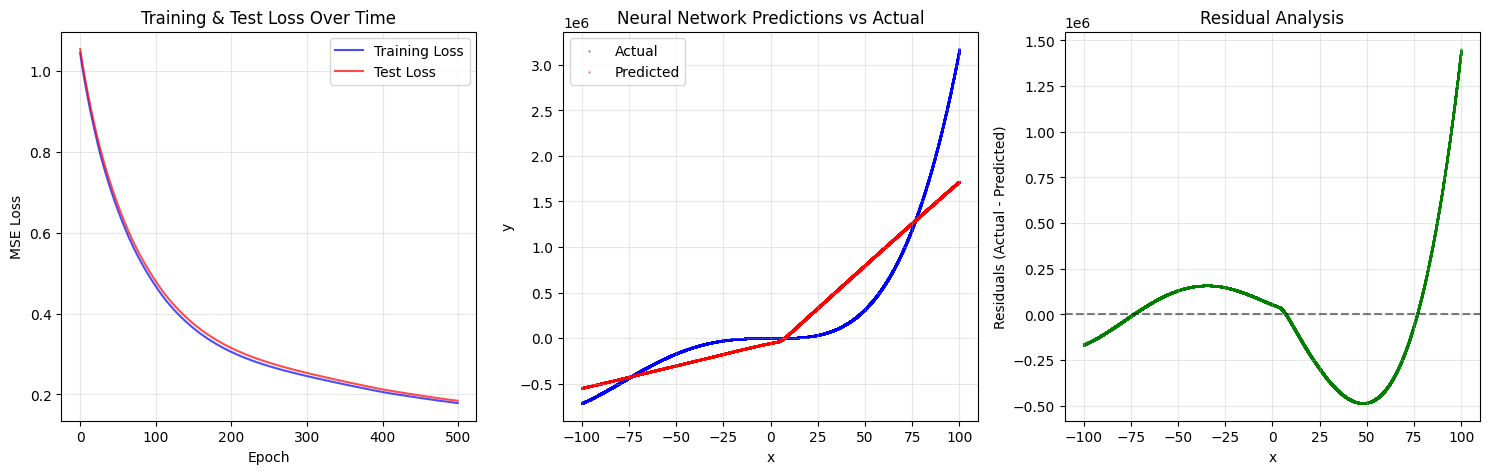

In [ ]:
# Plot training progress
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Test Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Get final predictions for visualization
W1, b1, W2, b2, W3, b3 = weights
_, _, _, _, Y_pred_scaled = forward_pass(X_test_scaled, W1, b1, W2, b2, W3, b3)

# Inverse transform to original scale
Y_test_orig = scaler_Y.inverse_transform(Y_test_scaled)
Y_pred_orig = scaler_Y.inverse_transform(Y_pred_scaled)
X_test_orig = scaler_X.inverse_transform(X_test_scaled)

# Predictions vs Actual
plt.subplot(1, 3, 2)
plt.scatter(X_test_orig, Y_test_orig, s=1, alpha=0.3, label='Actual', color='blue')
plt.scatter(X_test_orig, Y_pred_orig, s=1, alpha=0.3, label='Predicted', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Predictions vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 3, 3)
residuals = Y_test_orig.flatten() - Y_pred_orig.flatten()
plt.scatter(X_test_orig, residuals, s=1, alpha=0.3, color='green')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('x')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Analysis')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

SPECIFIC PREDICTION TEST

In [ ]:

x_test_value = 90.2
x_new = np.array([[x_test_value]])
x_new_scaled = scaler_X.transform(x_new)

_, _, _, _, y_pred_scaled = forward_pass(x_new_scaled, W1, b1, W2, b2, W3, b3)
y_pred = scaler_Y.inverse_transform(y_pred_scaled)

if poly_type == 0:
    _, b, c, d = coefficients
    y_true = b * x_test_value**2 + c * x_test_value + d

elif poly_type == 1:
    a, b, c, d = coefficients
    y_true = a * x_test_value**3 + b * x_test_value**2 + c * x_test_value + d

elif poly_type == 2:
    a, b, c, d, e = coefficients
    y_true = a * x_test_value**4 + b * x_test_value**3 + c * x_test_value**2 + d * x_test_value + e

elif poly_type == 3:
    a, b, c, d, freq, amp = coefficients
    y_true = a * x_test_value**3 + b * x_test_value**2 + c * x_test_value + d + amp * np.sin(freq * x_test_value)

else:
    a, b, c, d, inv_coeff = coefficients
    y_true = a * x_test_value**3 + b * x_test_value**2 + c * x_test_value + d + inv_coeff / (x_test_value + np.sign(x_test_value) * 0.1)

print("\n" + "="*60)
print("PREDICTION RESULTS FOR x = 90.2")
print("="*60)
print(f"Neural Network Prediction: {y_pred[0][0]:,.2f}")
print(f"Ground Truth (formula):    {y_true:,.2f}")
print(f"Absolute Error:            {abs(y_pred[0][0] - y_true):,.2f}")
print(f"Relative Error:            {abs(y_pred[0][0] - y_true)/abs(y_true)*100:.3f}%")




PREDICTION RESULTS FOR x = 90.2
Neural Network Prediction: 1,544,205.97
Ground Truth (formula):    2,239,437.00
Absolute Error:            695,231.03
Relative Error:            31.045%


# PERFORMANCE METRICS

In [ ]:
# Calculate final performance metrics
final_train_loss = train_losses[-1] if train_losses else float('inf')
final_test_loss = test_losses[-1] if test_losses else float('inf')

# Calculate R² score
y_test_mean = np.mean(Y_test_orig)
ss_res = np.sum((Y_test_orig - Y_pred_orig) ** 2)
ss_tot = np.sum((Y_test_orig - y_test_mean) ** 2)
r2_score = 1 - (ss_res / ss_tot)

print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"Final Training Loss: {final_train_loss:.6f}")
print(f"Final Test Loss:     {final_test_loss:.6f}")
print(f"R² Score:           {r2_score:.4f}")
print(f"Total Epochs Run:   {len(train_losses)}")


FINAL PERFORMANCE SUMMARY
Final Training Loss: 0.178754
Final Test Loss:     0.184399
R² Score:           0.8199
Total Epochs Run:   500
